# Dataset Extraction

Author: Michael Dear, April 2024

This notebook is based on the following DEA notebooks:
* [Parallel Processing With Dask Beginner's Guide](https://knowledge.dea.ga.gov.au/notebooks/Beginners_guide/09_Parallel_processing_with_Dask/)
* [Calculating Band Indices How-to](https://knowledge.dea.ga.gov.au/notebooks/How_to_guides/Calculating_band_indices/)
* [Generating Composite Images How-to](https://knowledge.dea.ga.gov.au/notebooks/How_to_guides/Generating_composites/)
* [Extract and Analyse Data for Multiple Polygons](https://knowledge.dea.ga.gov.au/notebooks/How_to_guides/Analyse_multiple_polygons/)


In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
import numpy as np
import warnings
import geopandas as gpd

from datacube.drivers.netcdf import write_dataset_to_netcdf

import sys
sys.path.insert(1, '../../Tools/')

from dea_tools.plotting import rgb, display_map
from dea_tools.datahandling import load_ard
from dea_tools.dask import create_local_dask_cluster
from dea_tools.bandindices import calculate_indices

# For masking using a polygon
from shapely.geometry import mapping

## Create Dask Client

In [2]:
# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

2024-04-22 08:09:58,999 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-tvqd0u8w', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/mjdear68@gmail.com/proxy/8787/status,
Dashboard: /user/mjdear68@gmail.com/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43909,Workers: 1
Dashboard: /user/mjdear68@gmail.com/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:32987,Total threads: 2
Dashboard: /user/mjdear68@gmail.com/proxy/42863/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:45501,


In [33]:
# client.close()

### Connect to the datacube
The next step is to connect to the datacube database.
The resulting `dc` datacube object can then be used to load data.
The `app` parameter is a unique name used to identify the notebook that does not have any effect on the analysis.

In [3]:
dc = datacube.Datacube(app="Create_dataset")

## Step 1: Choose a study area
Use *one* of the methods below to set the bounding box for the study area.

### Method 1: Bounding box from centre point

In [102]:
# Grose Valley, NSW
cpoint = (-33.5976, 150.3651)
buffer = 0.0875
study_area_lat = (cpoint[0]+buffer, cpoint[0]-buffer)
study_area_lon = (cpoint[1]-buffer, cpoint[1]+buffer)

### Method 2: Bounding box from polygon

In [9]:
# Load the polygon
poly = gpd.read_file('../data/vector/lockleys-pilon.geojson')

In [10]:
poly.head()

,Name,geometry
0,lockleys-pilon-outline,"POLYGON ((150.39334 -33.62688, 150.39343 -33.6..."


In [11]:
# Set the CRS to EPSG:4326
poly = poly.to_crs(4326)

<Axes: >

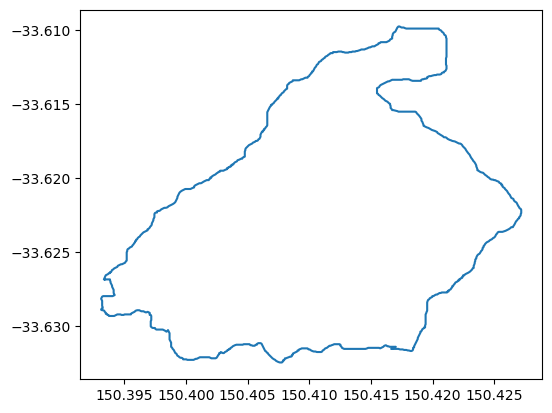

In [12]:
# Plot to check
poly.boundary.plot()

In [13]:
# Get the coordinates of the bounding box
bounds = poly.total_bounds
bounds

array([150.39312885, -33.63245231, 150.42718737, -33.60977046])

In [14]:
# Set the latitude and longitude
study_area_lat = (bounds[1], bounds[3])
study_area_lon = (bounds[0], bounds[2])

In [15]:
display_map(x=study_area_lon, y=study_area_lat)

## Step 2: Load data

In [35]:
# Turn off warnings to suppress dask all nan slice warnings
warnings.filterwarnings('ignore')

# Load available data 
ds = load_ard(dc=dc,
              products=["ga_s2am_ard_3"],
              measurements = ["nbart_red", "nbart_blue", "nbart_green", "nbart_nir_1"],
              x=study_area_lon,
              y=study_area_lat,
              time=('2020', '2023'),
              output_crs='EPSG:3577', # 3308 NSW Lambert; 3577 Australian Albers; 4326 does not work - not sure why
              resolution=(-10, 10),
              group_by='solar_day',
              # dask_chunks={"time": 1, "x": 2048 , "y": 2048},
              cloud_mask='s2cloudless' # Uncomment if using Sentinel data
             )

# Reset warnings
warnings.resetwarnings()

Finding datasets
    ga_s2am_ard_3
Applying fmask pixel quality/cloud mask
Returning 280 time steps as a dask array


In [20]:
# Uncomment and run this to close the Dask client if it is no longer required.
# client.close()

In [40]:
ds_dask

<xarray.Dataset>
Dimensions:      (time: 280, y: 239, x: 152)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-06T23:56:06.939367 ... 2023-12...
  * y            (y) float64 -3.646e+06 -3.646e+06 ... -3.882e+06 -3.884e+06
  * x            (x) float64 1.628e+06 1.63e+06 1.63e+06 ... 1.778e+06 1.78e+06
    spatial_ref  int32 3577
Data variables:
    nbart_red    (time, y, x) float32 dask.array<chunksize=(1, 239, 152), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 dask.array<chunksize=(1, 239, 152), meta=np.ndarray>
    nbart_green  (time, y, x) float32 dask.array<chunksize=(1, 239, 152), meta=np.ndarray>
    nbart_nir_1  (time, y, x) float32 dask.array<chunksize=(1, 239, 152), meta=np.ndarray>
    NDVI         (time, y, x) float32 dask.array<chunksize=(1, 239, 152), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [34]:
print('Dataset size = ', np.round(ds_dask.nbytes/1024**3,3), 'Gb')

Dataset size =  45.502 Gb


### Create additional variables
Using the DEA's `calculate_indices` function is a quick way to add common indices as variables to the dataset.

*Note*: This function will automatically add the new variable to the given dataset.

#### Collections
* For Landsat (i.e. GA Landsat Collection 3), specify collection='ga_ls_3'.
* For Sentinel 2 (i.e. GA Sentinel 2 Collection 3), specify collection='ga_s2_3'

In [36]:
# Add an NDVI variable
ds_dask = calculate_indices(ds_dask, index='NDVI', collection='ga_s2_3')

### Resample
Resampling along the time dimension can be useful for creating cloud-free composites and for reducing the size of the dataset. It is also possible to resample along the spatial dimensions, although it is probably easier to do this by changing the `resolution` in the `load_ard` function.

In [37]:
ds_resamp = ds_dask.resample(time='Y').median()

In [38]:
ds_resamp.NDVI.data

dask.array<concatenate, shape=(4, 239, 152), dtype=float32, chunksize=(1, 239, 152), chunktype=numpy.ndarray>

In [31]:
print('Dataset size = ', np.round(ds_resamp.nbytes/1024**3,3), 'Gb')

Dataset size =  0.401 Gb


### Load the dataset into memory
Loading the data can take a long time depending on the size of the study area and the duration of the study. Clicking the Dashboard link in the output from loading Dask at the beginning of the notebook will open a page showing the progress of the task.

Here are some ways to decrease the load time:
* Optimize the chunk size. This means experimenting with increasing or decreasing the number of `x` and `y` pixels in the `dask_chunks` parameter of the `load_ard` function. 1024 and 2048 are good places to start, but it depends on the size of your x and y dimensions. Leave `"time" : 1`.
* Reduce the spatial resolution in the `load_ard` function.
* Reduce the number of `products` in the `load_ard` function e.g. choose Sentinel 2A or Sentinel 2B  rather than both.
* Reduce the period in the `load_ard` function by changing the `time` parameter.
* Try a different time of day e.g. after work hours. 

In [39]:
ds = ds_resamp.load()

/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


## Step 3: Plotting data

After loading the data, it is useful to view it to understand the resolution, which observations are impacted by cloud cover, and whether there are any obvious differences between time steps.

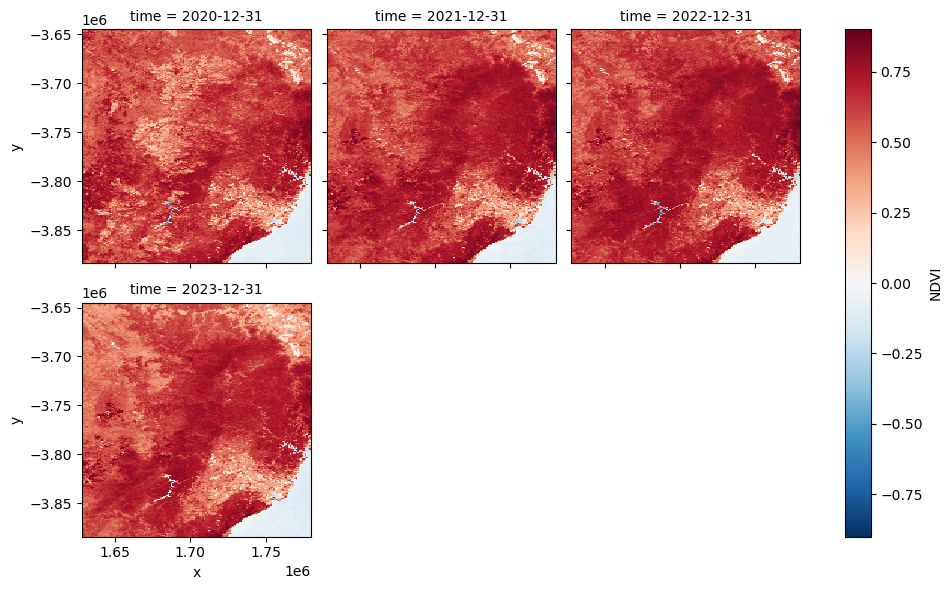

In [51]:
# Facetgrid plot of a single band
ds.NDVI.sel(time=slice('2020', '2023')).plot(col='time', col_wrap=3)

/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


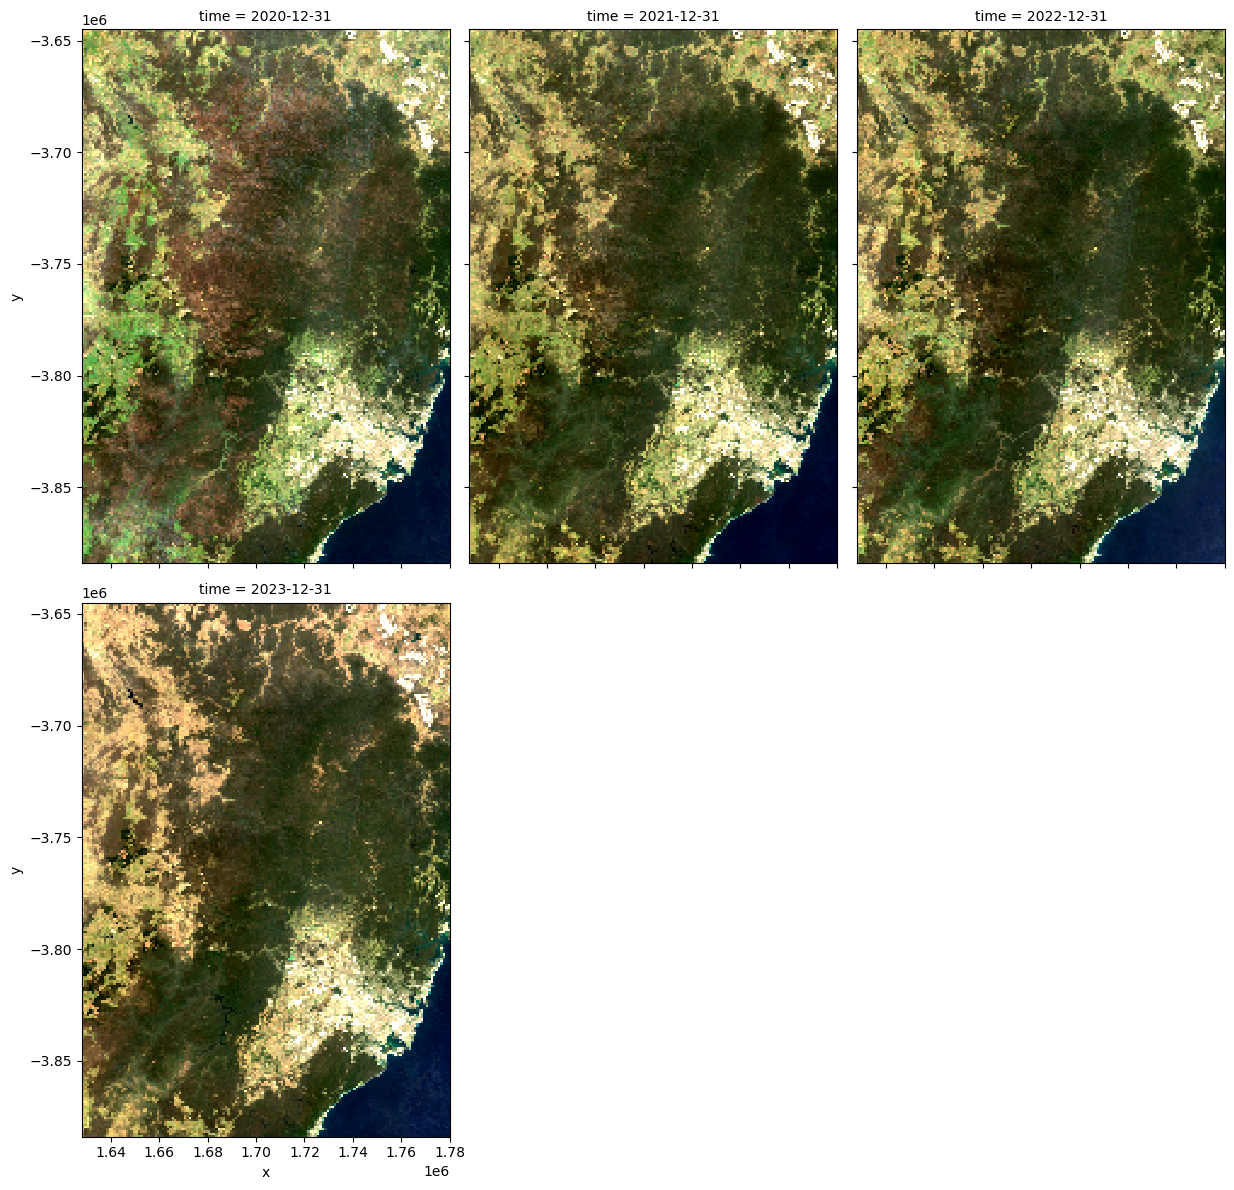

In [52]:
# RGB plot
rgb(ds.sel(time=slice('2020', '2023')), 
    bands=['nbart_red', 'nbart_green', 'nbart_blue'], 
    col='time',
    col_wrap=3)

## Optional Step: Clip to a Polygon Mask
If you used a polygon to set the bounds for your study area, you might like to clip the output to the same polygon before exporting the data. This involves defining a function to clip a data array, then applying this function to each band in the dataset.

In [72]:
# Make sure the polygon is in the preferred output CRS
print(poly.crs)
poly = poly.to_crs(ds.crs)
print(poly.crs)

EPSG:4326
EPSG:3577


In [53]:
def clip_da(da, geom):
    '''
    Clip a dataset by applying the clipping process to each data array recursively.
    '''
    return da.rio.clip(geom.geometry.apply(mapping), geom.crs, drop=False)

The next step is to apply the function to each band in the dataset. A dictionary comprehension is used to create the clipped data arrays which are then used to make the final dataset.

In [73]:
var_dict={var: clip_da(da=ds[var], geom=poly) for var in ds.data_vars}

In [74]:
ds_clip = xr.Dataset(var_dict)
ds_clip

<xarray.Dataset>
Dimensions:      (y: 239, x: 152, time: 4)
Coordinates:
  * y            (y) float64 -3.646e+06 -3.646e+06 ... -3.882e+06 -3.884e+06
  * x            (x) float64 1.628e+06 1.63e+06 1.63e+06 ... 1.778e+06 1.78e+06
  * time         (time) datetime64[ns] 2020-12-31 2021-12-31 ... 2023-12-31
    spatial_ref  int64 0
Data variables:
    nbart_red    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_blue   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_green  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_nir_1  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    NDVI         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan

/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


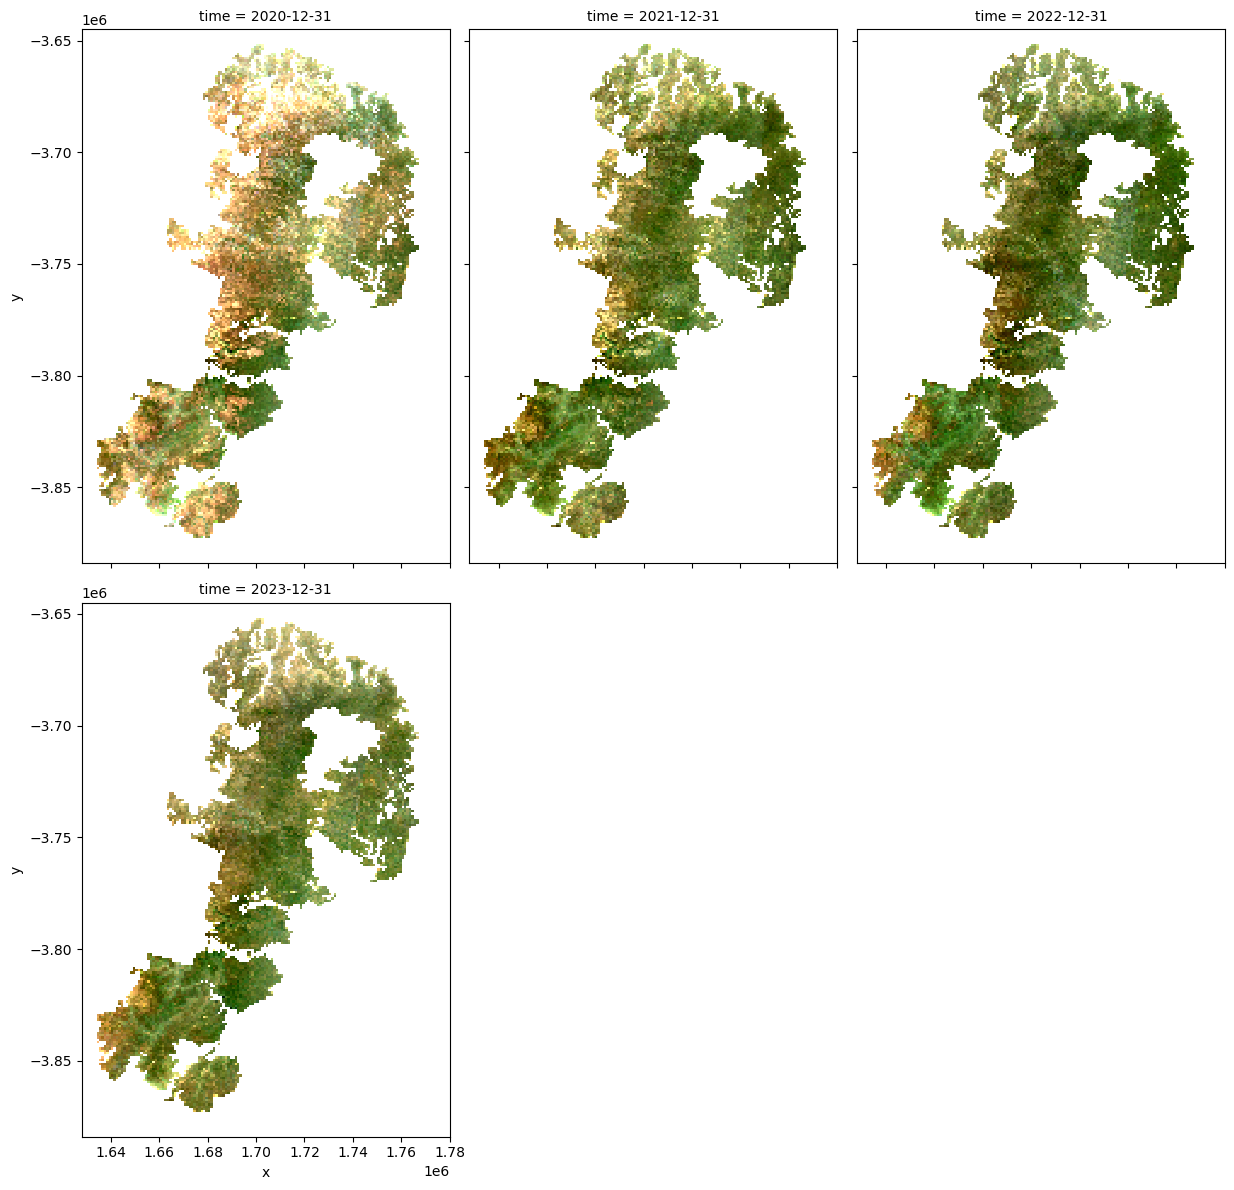

In [75]:
# RGB plot
rgb(ds_clip.sel(time=slice('2020', '2023')), 
    bands=['nbart_red', 'nbart_green', 'nbart_blue'], 
    col='time',
    col_wrap=3)

## Step 4: Exporting data

In [76]:
# Save clipped dataset as netCDF
ds_clip.to_netcdf('output/output_clip.nc')

In [77]:
# Remove CRS info because it prevents file saving
ds.time.attrs=[]

# Save as netCDF
ds.to_netcdf('output/output.nc')